In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler # Feature Scaling
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import matplotlib.pyplot as plt
import math
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE 
from lazypredict.Supervised import LazyClassifier

def convertDirectionInt(strIn):
    if(type(strIn) == str):
        if(strIn == "N"):
            return 0
        elif(strIn == "NNE"):
            return 1
        elif(strIn == "NE"):
            return 2
        elif(strIn == "ENE"):
            return 3
        elif(strIn == "E"):
            return 4
        elif(strIn == "ESE"):
            return 5
        elif(strIn == "SE"):
            return 6
        elif(strIn == "SSE"):
            return 7
        elif(strIn == "S"):
            return 8
        elif(strIn == "SSW"):
            return 9
        elif(strIn == "SW"):
            return 10
        elif(strIn == "WSW"):
            return 11
        elif(strIn == "W"):
            return 12
        elif(strIn == "WNW"):
            return 13
        elif(strIn == "NW"):
            return 14
        elif(strIn == "NNW"):
            return 15
    else:
        return strIn  

df = pd.read_csv("train.csv")
colNames = {'Attribute1':'date', 
           'Attribute2':'stationArea',
           'Attribute3':'minTemp', 
           'Attribute4':'maxTemp', 
           'Attribute5':'rainDrop', 
           'Attribute6':'evaporation', 
           'Attribute7':'daySunAppearHour', 
           'Attribute8':'strongestWindDir', 
           'Attribute9':'strongestWindSpd', 
           'Attribute10':'3pmWindDir', 
           'Attribute11':'3pmPrevAvgTemp', 
           'Attribute12':'3pmRltvHumid', 
           'Attribute13':'3pmPrevAtmPres', 
           'Attribute14':'3pmCloudProp', 
           'Attribute15':'3pmTemp', 
           'Attribute16':'TdyRain',
           'Attribute17':'TomorrowRain'}
df = df.rename(colNames, axis='columns')
df['stationArea'] = df['stationArea'].astype('object')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df.drop('date', axis = 1, inplace = True)
df["TomorrowRain"] = np.where(df["TomorrowRain"] == "Yes", 1, 0)
df["TdyRain"] = np.where(df["TdyRain"] == "Yes", 1, 0)
print(df.describe(include="all"))

print ("=========")

testdf = pd.read_csv("test.csv")
testdf = testdf.rename(colNames, axis='columns')
testdf['stationArea'] = testdf['stationArea'].astype('object')
testdf['date'] = pd.to_datetime(testdf['date'])
testdf['year'] = testdf['date'].dt.year
testdf['day'] = testdf['date'].dt.day
testdf['month'] = testdf['date'].dt.month
testdf.drop('date', axis = 1, inplace = True)
testdf["TdyRain"] = np.where(testdf["TdyRain"] == "Yes", 1, 0)
print(testdf.describe(include="all"))

#encode the strings to numbers


columnGroups = {'y': ['TomorrowRain'],
               'XAllDefault': ['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp', '3pmTemp', 'TdyRain'], 
                'XDefaultNoNull': ['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp', '3pmTemp', 'TdyRain'], #tried
                'XDefaultNoNullNoArea': ['minTemp', 'maxTemp', 'rainDrop', 
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp', '3pmTemp', 'TdyRain'], #tried
                'XDefaultNoNullNoAreaNoCorr': ['minTemp', 'maxTemp', 'rainDrop', 
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp', 'TdyRain'], #tried
               'XNumericDefault':['minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindSpd', 
                        '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp', '3pmTemp'], # 11 columns
               'XCategoryDefault': ['stationArea', 'strongestWindDir', '3pmWindDir', 'TdyRain'], #4 columns
               'LightGBMTrialData' : ['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp'],
                'RemoveSkewedNoEvap': ['stationArea', 'minTemp', 'maxTemp', 
                        'daySunAppearHour', 'strongestWindDir', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp', '3pmTemp', 'TdyRain'], 
                'XAll': ['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp', '3pmTemp', 'TdyRain','year', 'month', 'day'], 
                'XAllNo3pmTemp':['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp','TdyRain','year', 'month', 'day'],
                'XAllNo3pmTempNoStation':['minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp','TdyRain','year', 'month', 'day'],
                'XAllNo3pmTempNoStationDates':['minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp','TdyRain'],
                'XAllNo3pmTempNoStationDirections':['minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindSpd', 
                       '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp','TdyRain','year', 'month', 'day'],
                'XAllNo3pmTempDates':['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 'evaporation', 
                        'daySunAppearHour', 'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       '3pmCloudProp','TdyRain'],
                'XAllNo3pmTempNoNull':['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       'TdyRain','year', 'month', 'day'],
                'AllNo3pmTempEvaporation':['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 'daySunAppearHour',
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       'TdyRain','year', 'month', 'day', 'TomorrowRain'],
                'XAllNo3pmTempEvaporation':['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 'daySunAppearHour',
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       'TdyRain','year', 'month', 'day'],
                'XAllNo3pmTempEvaporationStationArea':['minTemp', 'maxTemp', 'rainDrop', 'daySunAppearHour',
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       'TdyRain','year', 'month', 'day'],
                'XAllNo3pmTempEvaporationStationAreaDates':['minTemp', 'maxTemp', 'rainDrop', 'daySunAppearHour',
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       'TdyRain'],
                'XAllNo3pmTempEvaporationStationAreaDirections':['minTemp', 'maxTemp', 'rainDrop', 'daySunAppearHour',
                        'strongestWindSpd', 
                       '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       'TdyRain'],
                'XAllNo3pmTempEvaporationDates':['stationArea', 'minTemp', 'maxTemp', 'rainDrop', 'daySunAppearHour',
                        'strongestWindDir', 'strongestWindSpd', 
                       '3pmWindDir', '3pmPrevAvgTemp', '3pmRltvHumid', '3pmPrevAtmPres', 
                       'TdyRain']}

        stationArea  minTemp  maxTemp  rainDrop  evaporation  \
count      17103.00 17032.00 17071.00  16942.00      9702.00   
unique        49.00      NaN      NaN       NaN          NaN   
top            9.00      NaN      NaN       NaN          NaN   
freq         430.00      NaN      NaN       NaN          NaN   
mean            NaN    12.09    23.32      2.16         5.50   
std             NaN     6.38     7.09      7.80         4.27   
min             NaN    -8.50    -2.90      0.00         0.00   
25%             NaN     7.50    18.00      0.00         2.60   
50%             NaN    11.95    22.70      0.00         4.80   
75%             NaN    16.70    28.40      0.60         7.40   
max             NaN    31.00    47.00    156.00        81.20   

        daySunAppearHour strongestWindDir  strongestWindSpd 3pmWindDir  \
count            8872.00            16010          16017.00      16671   
unique               NaN               16               NaN         16   
top      

In [2]:
df['TomorrowRain'].value_counts()/len(df)

0   0.82
1   0.18
Name: TomorrowRain, dtype: float64

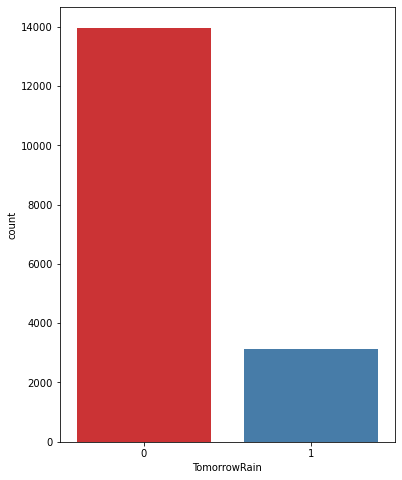

In [3]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="TomorrowRain", data=df, palette="Set1")
plt.show()

In [4]:
#view cardinality
for var in columnGroups["XCategoryDefault"]:
    print(var, ' contains ', len(df[var].unique()), ' labels')

stationArea  contains  49  labels
strongestWindDir  contains  17  labels
3pmWindDir  contains  17  labels
TdyRain  contains  2  labels


In [5]:
#Count how many empty values, in percentage
df.isnull().mean() * 100

stationArea         0.00
minTemp             0.42
maxTemp             0.19
rainDrop            0.94
evaporation        43.27
daySunAppearHour   48.13
strongestWindDir    6.39
strongestWindSpd    6.35
3pmWindDir          2.53
3pmPrevAvgTemp      1.79
3pmRltvHumid        2.43
3pmPrevAtmPres      9.76
3pmCloudProp       40.65
3pmTemp             1.72
TdyRain             0.00
TomorrowRain        0.00
year                0.00
day                 0.00
month               0.00
dtype: float64

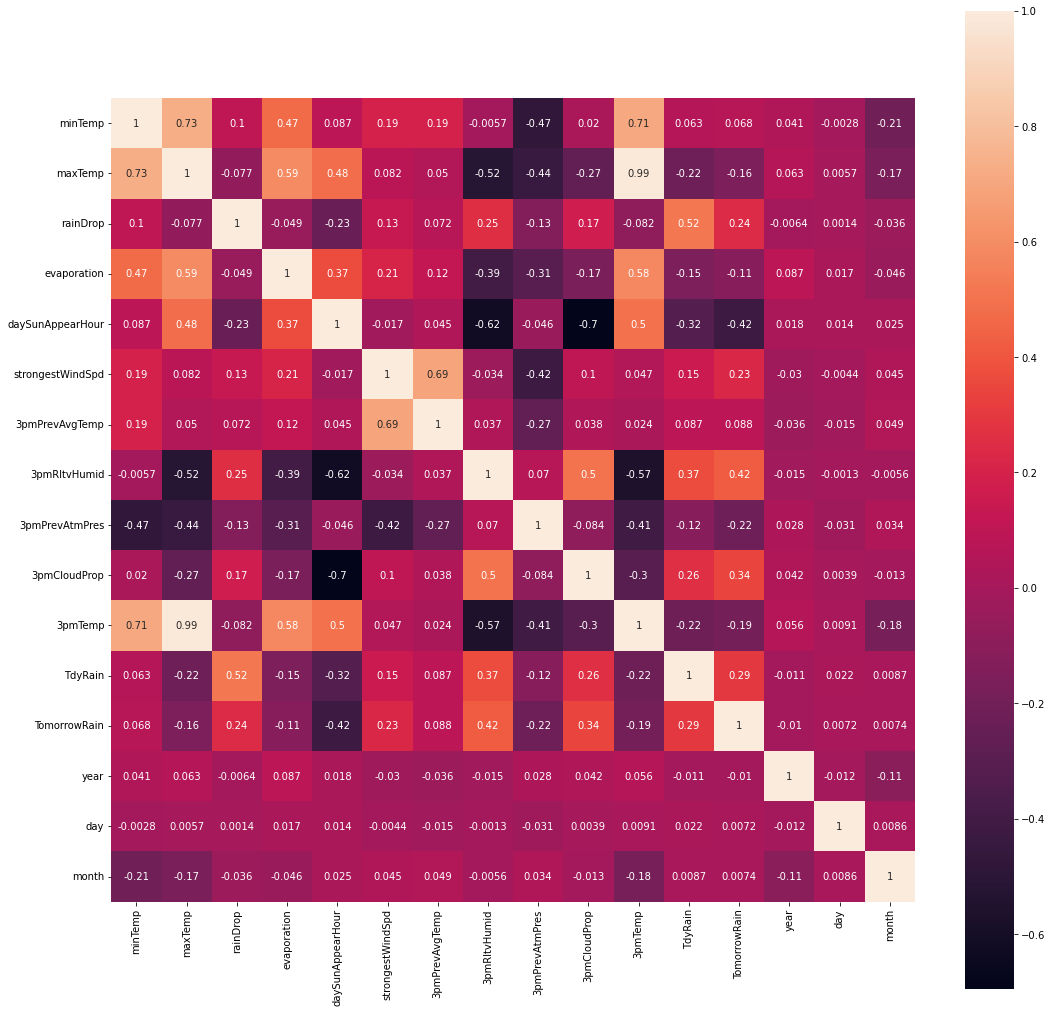

In [6]:
correlation = df.corr()
plt.figure(figsize=(18,18))
sns.heatmap(correlation, annot=True, square=True)
plt.show()
#3pm temp and maxtemp is really similar
#drop 3pm temp, because have more null
#although daySunAppearHour has a lot of null, but the column proves to be high correlated, so do 3pmCloudProp

strongestWindDir
3pmWindDir


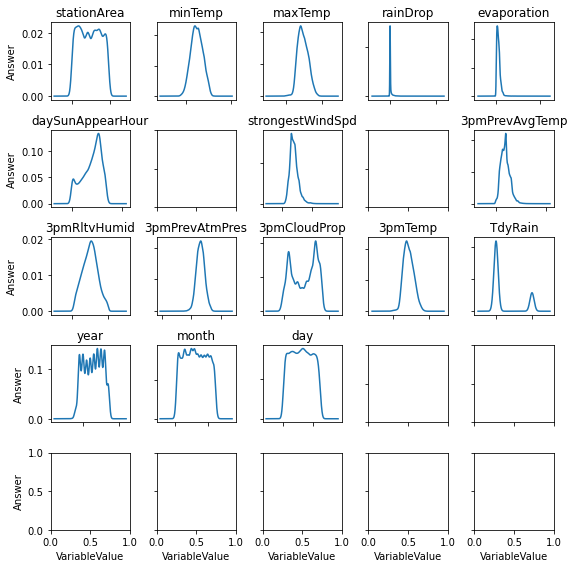

In [7]:
#plot graph
plt.rcParams["figure.figsize"] = [8.00, 8.00]
plt.rcParams["figure.autolayout"] = True
rowCol = math.ceil(math.sqrt(len(columnGroups['XAll'])))
fig, axs = plt.subplots(rowCol, rowCol)
for i in range(len(columnGroups['XAll'])):
    try:
        df[columnGroups['XAll'][i]].plot(kind = "kde", ax = axs[i//rowCol, i%rowCol])
        axs[i//rowCol, i%rowCol].set_title(columnGroups['XAll'][i])
    except TypeError:
        print(columnGroups['XAll'][i])
for ax in axs.flat:
    ax.set(xlabel='VariableValue', ylabel='Answer')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#We can see that some of the graph is really skewed, e.g. Evaporation, rainDrop

strongestWindDir
3pmWindDir


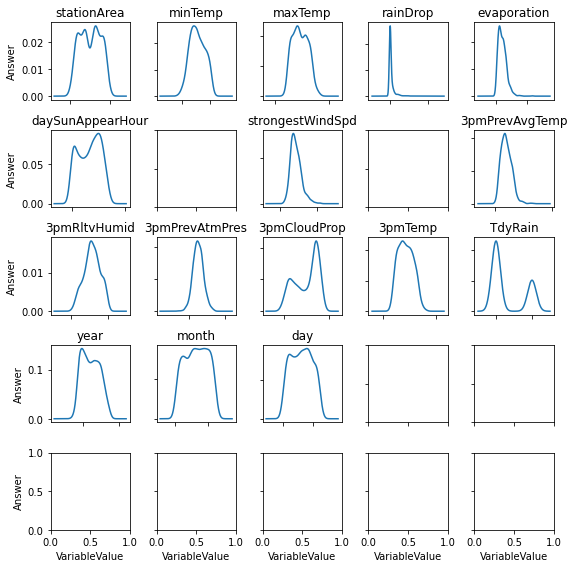

In [8]:
#try test
#plot graph
plt.rcParams["figure.figsize"] = [8.00, 8.00]
plt.rcParams["figure.autolayout"] = True
rowCol = math.ceil(math.sqrt(len(columnGroups['XAll'])))
fig, axs = plt.subplots(rowCol, rowCol)
for i in range(len(columnGroups['XAll'])):
    try:
        testdf[columnGroups['XAll'][i]].plot(kind = "kde", ax = axs[i//rowCol, i%rowCol])
        axs[i//rowCol, i%rowCol].set_title(columnGroups['XAll'][i])
    except TypeError:
        print(columnGroups['XAll'][i])
for ax in axs.flat:
    ax.set(xlabel='VariableValue', ylabel='Answer')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#But looking at these graphs, the one on test set are also skewed, although a bit better, so
#can conclude that do not drop the outlier, but try to transform the skew to be similar to
#normal distribution

8239
1515
strongestWindDir
3pmWindDir


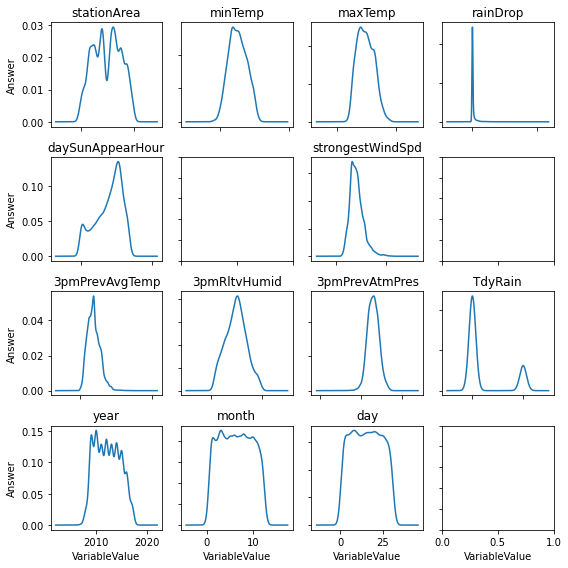

In [9]:
dfNoNulls =  df[columnGroups["AllNo3pmTempEvaporation"]].copy()
dfNoNulls = dfNoNulls.dropna()
print(len(dfNoNulls))
print(sum(dfNoNulls["TomorrowRain"]))
#plot graph
plt.rcParams["figure.figsize"] = [8.00, 8.00]
plt.rcParams["figure.autolayout"] = True
rowCol = math.ceil(math.sqrt(len(columnGroups['XAllNo3pmTempEvaporation'])))
fig, axs = plt.subplots(rowCol, rowCol)
for i in range(len(columnGroups['XAllNo3pmTempEvaporation'])):
    try:
        dfNoNulls[columnGroups['XAllNo3pmTempEvaporation'][i]].plot(kind = "kde", ax = axs[i//rowCol, i%rowCol])
        axs[i//rowCol, i%rowCol].set_title(columnGroups['XAllNo3pmTempEvaporation'][i])
    except TypeError:
        print(columnGroups['XAllNo3pmTempEvaporation'][i])
for ax in axs.flat:
    ax.set(xlabel='VariableValue', ylabel='Answer')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#We can see that some of the graph is really skewed, e.g. Evaporation, rainDrop

# Model Building

In [10]:
#convert string of direction to int
for i in range(len(df)):
    if(type(df.at[i,'strongestWindDir']) == str):
        df.at[i,'strongestWindDir'] = convertDirectionInt(df.at[i,'strongestWindDir'])
    if(type(df.at[i,'3pmWindDir']) == str):
        df.at[i,'3pmWindDir'] = convertDirectionInt(df.at[i,'3pmWindDir'])
df['strongestWindDir'] = pd.to_numeric(df['strongestWindDir'])
df['3pmWindDir'] = pd.to_numeric(df['3pmWindDir'])

for i in range(len(testdf)):
    if(type(testdf.at[i,'strongestWindDir']) == str):
        testdf.at[i,'strongestWindDir'] = convertDirectionInt(testdf.at[i,'strongestWindDir'])
    if(type(testdf.at[i,'3pmWindDir']) == str):
        testdf.at[i,'3pmWindDir'] = convertDirectionInt(testdf.at[i,'3pmWindDir'])
testdf['strongestWindDir'] = pd.to_numeric(testdf['strongestWindDir'])
testdf['3pmWindDir'] = pd.to_numeric(testdf['3pmWindDir'])

In [30]:
#fix the empty values or nan
#try using knn
#reload dataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler # Feature Scaling
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import optuna
import tensorflow as tf
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from keras.backend import clear_session
from keras.layers import Dense
from keras.models import Sequential
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from numpy import sqrt, argmax

"""
XGBoost best
datasetConfig = {"columnGroups": "XAllNo3pmTempNoStation",
            "val?": False, 
           "valRatio":0.2,
            "NullKNN?":False,
            "KNNReplacement":5,
            "FillNumNull":"Median",
            "FillCatNull":"Mode", 
            "DropNulls?":False,
           "skewFix?":True,
            "OneHotEncoding?":True,
           "Scaler": "Robust",
            "Oversampling?": True,
           "Oversampling_method": "SMOTE",
            "FeatureSelection?":False, 
            "PCA?":False, 
            "FitWithEval?":False
           }

kernelConfig = {"LazyPredict":False,
                "OptunaMode":False,
               "NotOptunaFinalPredict":True, 
               "thresh":0.2, 
               "Model":"XGBOOST", #XGBOOST or RF or LOGREG
               }
               
"""
datasetConfig = {"columnGroups": "XAllNo3pmTempEvaporation",
            "val?": False, 
           "valRatio":0.2,
            "NullKNN?":False,
            "KNNReplacement":5,
            "FillNumNull":"Median",
            "FillCatNull":"Mode", 
            "DropNulls?":True,
           "skewFix?":True,
            "OneHotEncoding?":True,
           "Scaler": "Standard",
            "Oversampling?": True,
           "Oversampling_method": "SMOTE",
            "FeatureSelection?":False, 
            "PCA?":True, 
            "FitWithEval?":False
           }

kernelConfig = {"LazyPredict":False,
                "OptunaMode":False,
               "NotOptunaFinalPredict":True, 
               "thresh":0.4633, 
               "Model":"LOGREG", #XGBOOST or RF or LOGREG
               }
'''
best logreg
datasetConfig = {"columnGroups": "XAllNo3pmTempEvaporation",
            "val?": True, 
           "valRatio":0.2,
            "NullKNN?":False,
            "KNNReplacement":5,
            "FillNumNull":"Median",
            "FillCatNull":"Mode", 
            "DropNulls?":True,
           "skewFix?":True,
            "OneHotEncoding?":True,
           "Scaler": "Standard",
            "Oversampling?": True,
           "Oversampling_method": "SMOTE",
            "FeatureSelection?":False, 
            "PCA?":True, 
            "FitWithEval?":False
           }

kernelConfig = {"LazyPredict":False,
                "OptunaMode":False,
               "NotOptunaFinalPredict":True, 
               "thresh":0.4633, 
               "Model":"LOGREG", #XGBOOST or RF or LOGREG
               }
'''

'''
best logreg class weight
datasetConfig = {"columnGroups": "XAllNo3pmTempEvaporation",
            "val?": False, 
           "valRatio":0.2,
            "NullKNN?":False,
            "KNNReplacement":5,
            "FillNumNull":"Median",
            "FillCatNull":"Mode", 
            "DropNulls?":True,
           "skewFix?":True,
            "OneHotEncoding?":True,
           "Scaler": "Standard",
            "Oversampling?": True,
           "Oversampling_method": "SMOTE",
            "FeatureSelection?":False, 
            "PCA?":True, 
            "FitWithEval?":False
           }

kernelConfig = {"LazyPredict":False,
                "OptunaMode":False,
               "NotOptunaFinalPredict":True, 
               "thresh":0.463300, 
               "Model":"LOGREG_balanced", #XGBOOST or RF or LOGREG or LOGREG_balanced
               }
'''


'''
RF Best
datasetConfig = {"columnGroups": "XAllNo3pmTempEvaporation",
            "val?": False, 
           "valRatio":0.2,
            "NullKNN?":False,
            "KNNReplacement":5,
            "FillNumNull":"Median",
            "FillCatNull":"Mode", 
            "DropNulls?":True,
           "skewFix?":False,
            "OneHotEncoding?":False,
           "Scaler": None,
            "Oversampling?": False,
           "Oversampling_method": "SMOTE",
            "FeatureSelection?":False, 
            "PCA?":False, 
            "FitWithEval?":False
           }

kernelConfig = {"LazyPredict":False,
                "OptunaMode":False,
               "NotOptunaFinalPredict":True, 
               "thresh":0.19, 
               "Model":"RF", #XGBOOST or RF or LOGREG
               }
'''
                
y = df["TomorrowRain"].copy()
X = df[columnGroups[datasetConfig["columnGroups"]]].copy()
colNamesOrdered = list(X.columns)

if datasetConfig["DropNulls?"]:
    dfNoNulls =  df.copy()
    dfNoNulls = dfNoNulls.dropna()
    y = dfNoNulls["TomorrowRain"].copy()
    X = dfNoNulls[columnGroups[datasetConfig["columnGroups"]]].copy()
    colNamesOrdered = list(X.columns)
else:
    y = df["TomorrowRain"].copy()
    X = df[columnGroups[datasetConfig["columnGroups"]]].copy()
    colNamesOrdered = list(X.columns)

if datasetConfig["val?"]:
    Xtrain, Xval, ytrain, yval = train_test_split(X, y, stratify=y, test_size=datasetConfig["valRatio"], random_state=1)
    Xtrain.index = [i for i in range(len(Xtrain))]
    Xval.index = [i for i in range(len(Xval))]
    ytrain.index = [i for i in range(len(ytrain))]
    yval.index = [i for i in range(len(yval))]
    """
    print("-------")
    for i in range(len(y)):
        print(ytrain[i])
    print("-------")
    """
else:
    Xtrain = X.copy()
    ytrain = y.copy()

#Fill Null using KNN
if not datasetConfig["DropNulls?"]:
    if datasetConfig["NullKNN?"]:
        valid_rows = Xtrain.notna().all(axis='columns')
        valid_indices = valid_rows[valid_rows==True]
        inval_indices = valid_rows[valid_rows==False]
        valid_indices = list(valid_indices.index)
        print(len(valid_indices))
        inval_indices = list(inval_indices.index)

        imputer = KNNImputer(n_neighbors=datasetConfig["KNNReplacement"])
        imputer = imputer.fit(Xtrain.iloc[valid_indices])

        Xtrain = imputer.transform(Xtrain)
        if datasetConfig["val?"]:
            Xval = imputer.transform(Xval)
        ytrain = ytrain.values
        if datasetConfig["val?"]:
            yval = yval.values
    #Fill the NumNull and CatNull, 
    else:
        cols = Xtrain.columns
        replacementVal = {}
        for col in cols:
            if col in columnGroups['XCategoryDefault']:
                if datasetConfig["FillCatNull"] == "Mode":
                    replacementVal[col] = Xtrain[col].mode()[0]
                elif datasetConfig["FillCatNull"] == "Mean":
                    replacementVal[col] = Xtrain[col].mean()
                elif datasetConfig["FillCatNull"] == "Median":
                    replacementVal[col] = Xtrain[col].median()
                else:
                    raise ValueError("FillCatNull value invalid")
            else:
                if datasetConfig["FillNumNull"] == "Mode":
                    replacementVal[col] = Xtrain[col].mode()[0]
                elif datasetConfig["FillNumNull"] == "Mean":
                    replacementVal[col] = Xtrain[col].mean()
                elif datasetConfig["FillNumNull"] == "Median":
                    replacementVal[col] = Xtrain[col].median()
                else:
                    raise ValueError("FillNumNull value invalid")
        Xtrain = Xtrain.fillna(replacementVal)
        Xtrain = Xtrain.values
        ytrain = ytrain.values
        if datasetConfig["val?"]:
            Xval = Xval.fillna(replacementVal)
            Xval = Xval.values
            yval = yval.values
else:
    Xtrain = Xtrain.values
    ytrain = ytrain.values
    if datasetConfig["val?"]:
        Xval = Xval.values
        yval = yval.values

#split categorical and numerical
categoryIndices = []
numericIndices = []
for i in range(len(colNamesOrdered)):
    if colNamesOrdered[i] in columnGroups['XCategoryDefault']:
        categoryIndices.append(i)
    else:
        numericIndices.append(i)
XtrainNumeric = Xtrain[:, numericIndices]
XtrainCategory = Xtrain[:, categoryIndices]
if datasetConfig["val?"]:
    XvalNumeric = Xval[:, numericIndices]
    XvalCategory = Xval[:, categoryIndices]
    
#repair skew only for numerical data
if datasetConfig["skewFix?"]:
    skewFixer = ColumnTransformer(transformers=[('PowerTransform', PowerTransformer(standardize = False), [i for i in range(XtrainNumeric.shape[1])])], remainder = "drop")
    XtrainNumeric = skewFixer.fit_transform(XtrainNumeric)
    #XtrainNumeric = XtrainNumeric.toarray()
    
    if datasetConfig["val?"]:
        XvalNumeric = skewFixer.transform(XvalNumeric)
        #XvalNumeric.toarray()

#scale, both one hot encoding and also 
if datasetConfig["Scaler"] != None:
    scalerNumeric = None
    scalerCategory = None
    if datasetConfig["Scaler"] == "Robust":
        scalerNumeric = RobustScaler()
        scalerCategory = RobustScaler()
    elif datasetConfig["Scaler"] == "Standard":
        scalerNumeric = StandardScaler()
        scalerCategory = StandardScaler()
    elif datasetConfig["Scaler"] == "MinMax":
        scalerNumeric = MinMaxScaler()
        scalerCategory = MinMaxScaler()
    elif datasetConfig["Scaler"] != None:
        raise ValueError("Scaler invalid")
    XtrainNumeric = scalerNumeric.fit_transform(XtrainNumeric)
    XtrainCategory = scalerCategory.fit_transform(XtrainCategory)
    if datasetConfig["val?"]:
        XvalNumeric = scalerNumeric.transform(XvalNumeric)
        XvalCategory = scalerCategory.transform(XvalCategory)
        
#PCA
if datasetConfig["PCA?"]:
    PCATrans = PCA()
    XtrainNumeric = PCATrans.fit_transform(XtrainNumeric)
    if datasetConfig["val?"]:
        XvalNumeric = PCATrans.transform(XvalNumeric)

#One hot encoding if necessary for categorical columns
if datasetConfig["OneHotEncoding?"]:
    oneHot = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop = 'first'), [i for i in range(XtrainCategory.shape[1])])], remainder = 'drop')
    XtrainCategory = oneHot.fit_transform(XtrainCategory)
    XtrainCategory = XtrainCategory.toarray()
    if datasetConfig["val?"]:
        XvalCategory = oneHot.transform(XvalCategory)
        XvalCategory = XvalCategory.toarray()
        
#Concat the numeric and category
Xtrain = np.concatenate([XtrainNumeric, XtrainCategory], axis = 1)
if datasetConfig["val?"]:
    Xval = np.concatenate([XvalNumeric, XvalCategory], axis = 1)
    
#Oversample the train set only, not the val set
if datasetConfig["Oversampling?"]:
    if datasetConfig["Oversampling_method"] == "SMOTE":
        """
        for i in range(len(ytrain)):
            if ytrain[i] == np.nan:
                print(f"nan {i}")
            else:
                print(ytrain[i])
        for i in range(Xtrain.shape[0]):
            for j in range(Xtrain.shape[1]):
                if Xtrain[i][j] == np.nan:
                    print(f"x nan {i}{j}")
        print("========")
        np.where(np.isnan(ytrain))
        print("========")
        """
        Xtrain, ytrain = SMOTE(random_state = 2).fit_resample(Xtrain, ytrain)
    else:
        raise ValueError("Oversampling invalid")

#Metrics definition:
#Precision = TP / (TP+FP)
#Recall = TP / (TP + FN)
#begin training

if datasetConfig["FeatureSelection?"]:
    print("Feature selecting...")
    clf = xgb.XGBClassifier()
    trans = RFECV(clf)
    Xtrain = trans.fit_transform(Xtrain, ytrain)
    if(datasetConfig["val?"]):
        Xval = trans.transform(Xval)

def xgboost_objective(trial): 
    xgb_params_tweak = {
        "max_depth": trial.suggest_categorical("max_depth", [1,2,3,4,5,6]),
        "min_child_weight": trial.suggest_categorical("min_child_weight", [1,2,3,4,5,6]),
        "subsample": trial.suggest_categorical("subsample", [0.3,0.4,0.5,0.7,0.88,1]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.2,0.4,0.5,0.7,0.88,1]),
        'eta': trial.suggest_categorical('eta', [0.01, 0.1, 0.3]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 1, 5, 10]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [1, 5, 10, 20]),
        'n_estimators': trial.suggest_categorical('n_estimators', [25, 50, 100]),
        
    }
    thresh = trial.suggest_categorical("thresh", [0.1,0.2,0.3,0.4,0.5])
    model = xgb.XGBClassifier()
    model.set_params(**xgb_params_tweak)
    model.fit(Xtrain,ytrain, eval_metric = "auc", eval_set = [(Xval, yval)], verbose = False)
    
    predTrain = model.predict(Xtrain)
    
    predTrain = model.predict_proba(Xtrain)[:, 1]
    for i in range(predTrain.shape[0]):
        if predTrain[i] < thresh:
            predTrain[i] = 0
        else:
            predTrain[i] = 1
            
    print(f"Accuracy train: {metrics.accuracy_score(predTrain, ytrain)}")
    print(f"Precision, recall, fscore train: {metrics.precision_recall_fscore_support(predTrain, ytrain, average = 'binary')}")
    if datasetConfig["val?"]:
        predVal = model.predict(Xval)
        print(f"Accuracy test: {metrics.accuracy_score(predVal, yval)}")
        print(f"Precision, recall, fscore train: {metrics.precision_recall_fscore_support(predVal, yval, average = 'binary')}")
        return metrics.accuracy_score(predVal, yval)
        return metrics.precision_recall_fscore_support(predVal, yval, average = 'binary')[2]
    return metrics.precision_recall_fscore_support(predTrain, ytrain, average = 'binary')[2]


def logreg_objective(trial):
    params = {
        'solver': trial.suggest_categorical('solver',  ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'tol' : trial.suggest_categorical('tol' , [1e-6 , 1e-3]),
        'C' : trial.suggest_categorical("C", [100,10,1,0.1,0.01]),
        'max_iter':trial.suggest_categorical("max_iter", [50,100,300,500,1000,2000]),
       # 'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
       #  'random_state' : trial.suggest_categorical('random_state' , [0, 42, 2021, 555]),
       # 'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
    }
    thresh = trial.suggest_categorical("thresh", [0.1,0.2,0.3,0.4,0.5])
    model = LogisticRegression(**params, random_state = 2020)
    model.fit(Xtrain,ytrain)
    
    #predTrain = model.predict(Xtrain)
    
    predTrain = model.predict_proba(Xtrain)[:, 1]
    for i in range(predTrain.shape[0]):
        if predTrain[i] < thresh:
            predTrain[i] = 0
        else:
            predTrain[i] = 1
            
    print(f"Accuracy train: {metrics.accuracy_score(predTrain, ytrain)}")
    print(f"Precision, recall, fscore train: {metrics.precision_recall_fscore_support(predTrain, ytrain, average = 'binary')}")
    if datasetConfig["val?"]:
        #predVal = model.predict(Xval)
        
        predVal = model.predict_proba(Xval)[:, 1]
        for i in range(predVal.shape[0]):
            if predVal[i] < thresh:
                predVal[i] = 0
            else:
                predVal[i] = 1
        
        
        print(f"Accuracy test: {metrics.accuracy_score(predVal, yval)}")
        print(f"Precision, recall, fscore train: {metrics.precision_recall_fscore_support(predVal, yval, average = 'binary')}")
        #return metrics.accuracy_score(predVal, yval)
        return metrics.precision_recall_fscore_support(predVal, yval, average = 'binary')[2]
    return metrics.precision_recall_fscore_support(predTrain, ytrain, average = 'binary')[2]

def logreg_balanced_objective(trial):
    params = {
        'solver': trial.suggest_categorical('solver',  ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'tol' : trial.suggest_categorical('tol' , [1e-6 , 1e-3]),
        'C' : trial.suggest_categorical("C", [100,10,1,0.1,0.01]),
        'max_iter':trial.suggest_categorical("max_iter", [50,100,300,500,1000,2000]),
        'class_weight':'balanced'
       # 'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
       #  'random_state' : trial.suggest_categorical('random_state' , [0, 42, 2021, 555]),
       # 'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
    }
    thresh = trial.suggest_categorical("thresh", [0.1,0.2,0.3,0.4,0.5])
    model = LogisticRegression(**params, random_state = 2020)
    model.fit(Xtrain,ytrain)
    
    #predTrain = model.predict(Xtrain)
    
    predTrain = model.predict_proba(Xtrain)[:, 1]
    for i in range(predTrain.shape[0]):
        if predTrain[i] < thresh:
            predTrain[i] = 0
        else:
            predTrain[i] = 1
            
    print(f"Accuracy train: {metrics.accuracy_score(predTrain, ytrain)}")
    print(f"Precision, recall, fscore train: {metrics.precision_recall_fscore_support(predTrain, ytrain, average = 'binary')}")
    if datasetConfig["val?"]:
        #predVal = model.predict(Xval)
        
        predVal = model.predict_proba(Xval)[:, 1]
        for i in range(predVal.shape[0]):
            if predVal[i] < thresh:
                predVal[i] = 0
            else:
                predVal[i] = 1
        
        
        print(f"Accuracy test: {metrics.accuracy_score(predVal, yval)}")
        print(f"Precision, recall, fscore train: {metrics.precision_recall_fscore_support(predVal, yval, average = 'binary')}")
        #return metrics.accuracy_score(predVal, yval)
        return metrics.precision_recall_fscore_support(predVal, yval, average = 'binary')[2]
    return metrics.precision_recall_fscore_support(predTrain, ytrain, average = 'binary')[2]

if kernelConfig["LazyPredict"]:
    assert datasetConfig["val?"] == True
    clf = LazyClassifier(verbose = 0, ignore_warnings = True, custom_metric = None)
    models, predictions = clf.fit(Xtrain, Xval, ytrain, yval)
    print(models)
elif kernelConfig["OptunaMode"]:
    #study = optuna.create_study(direction = "maximize")
    #study.optimize(xgboost_objective, n_trials = 150)
    #optuna best result for no3pmTemp: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.88, 'colsample_bytree': 1, 'eta': 0.3, 'reg_alpha': 5, 'reg_lambda': 1, 'n_estimators': 100}
    #optuna best result for no3pmTempDates: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 1, 'colsample_bytree': 1, 'eta': 0.3, 'reg_alpha': 0, 'reg_lambda': 20, 'n_estimators': 100}
    
    #logreg
    #study = optuna.create_study(direction = "maximize")
    #study.optimize(logreg_objective, n_trials = 150)
    
    #logreg balanced
    study = optuna.create_study(direction = "maximize")
    study.optimize(logreg_balanced_objective, n_trials = 150)
else:
    xgb_params_tweak_no3pm_notoversampled = {
        "max_depth": 6,
        "min_child_weight": 5,
        "subsample": 0.88,
        "colsample_bytree": 1,
        'eta': 0.3,
        'reg_alpha': 5,
        'reg_lambda': 1,
        'n_estimators': 100,
        
    }
    
    xgb_params_tweak_no3pm_no3pmdates_notoversampled = {
        "max_depth": 6,
        "min_child_weight": 2,
        "subsample": 1,
        "colsample_bytree": 1,
        'eta': 0.3,
        'reg_alpha': 0,
        'reg_lambda': 20,
        'n_estimators': 100,
        
    }
    
    xgb_params_tweak_no3pm_oversampled = {'max_depth': 6, 
                                          'min_child_weight': 6, 
                                          'subsample': 0.7, 
                                          'colsample_bytree': 1, 
                                          'eta': 0.3, 
                                          'reg_alpha': 1, 
                                          'reg_lambda': 5, 
                                          'n_estimators': 50}
    xgb_params_tweak_no3pmdates_oversampled = {'max_depth': 5, 
                                                     'min_child_weight': 5, 
                                                     'subsample': 0.7, 
                                                     'colsample_bytree': 0.5, 
                                                     'eta': 0.3, 
                                                     'reg_alpha': 0, 
                                                     'reg_lambda': 1,}
    if kernelConfig["Model"] == "XGBOOST":     
        model = xgb.XGBClassifier()
        #model.set_params(**xgb_params_tweak_no3pm_notoversampled)
        #model.set_params(**xgb_params_tweak_no3pmdates_notoversampled)
        model.set_params(**xgb_params_tweak_no3pm_oversampled)
        #model.set_params(**xgb_params_tweak_no3pmdates_oversampled)
    elif kernelConfig["Model"] == "RF":
        model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', min_samples_leaf = 10, max_depth = 10, min_samples_split = 10, random_state = 42)
    elif kernelConfig["Model"] == "LOGREG":
        # optuna good params: 'solver': 'sag', 'penalty': 'l2', 'tol': 1e-06, 'C': 0.1, 'max_iter': 2000, 'thresh': 0.5
        logreg_params = {
            'solver': 'sag',
            'penalty': 'l2',
            'tol' : 1e-06,
            'C' : 0.1,
            'max_iter':2000,
       
        }
        #model = LogisticRegression()
        model = LogisticRegression(**logreg_params, random_state = 2020)
    elif kernelConfig["Model"] == "LOGREG_balanced":
        #use balanced weight
        logreg_params = {'solver': 'newton-cg', 
                         'penalty': 'l2', 
                         'tol': 1e-06, 
                         'C': 0.1, 
                         'max_iter': 100, 
                        'class_weight':'balanced'}
        model = LogisticRegression(**logreg_params, random_state = 2020)
    else:
        raise ValueError("Model name not recognized")
    if datasetConfig["FitWithEval?"]:
        assert datasetConfig["val?"]
        model.fit(Xtrain,ytrain,eval_set=[(Xtrain, ytrain), (Xval,yval)])
        
        # retrieve performance metrics
        results = model.evals_result()
        print(results)
        # plot learning curves
        plt.plot(results['validation_0']['logloss'], label='train')
        plt.plot(results['validation_1']['logloss'], label='test')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()
    else:
        model.fit(Xtrain,ytrain)
        #print("printing impotance:")
        #print(model.feature_importances_)
    #predTrain = model.predict(Xtrain)
    
    predTrain = model.predict_proba(Xtrain)[:,1]
    for i in range(predTrain.shape[0]):
        if predTrain[i] < kernelConfig['thresh']:
            predTrain[i] = 0
        else:
            predTrain[i] = 1
    
    print(f"Accuracy train: {metrics.accuracy_score(predTrain, ytrain)}")
    print(f"Precision, recall, fscore train: {metrics.precision_recall_fscore_support(predTrain, ytrain, average = 'binary')}")
    if datasetConfig["val?"]:
        #predVal = model.predict(Xval)
        
        predVal = model.predict_proba(Xval)[:,1]
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(yval, predVal)
        # plot the roc curve for the model
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Logistic')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        # show the plot
        plt.show()
        
        #calculate best threshold
        # calculate the g-mean for each threshold
        gmeans = sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
        
        for i in range(predVal.shape[0]):
            if predVal[i] < kernelConfig['thresh']:
                predVal[i] = 0
            else:
                predVal[i] = 1
        
        print(f"Accuracy test: {metrics.accuracy_score(predVal, yval)}")
        print(f"Precision, recall, fscore train: {metrics.precision_recall_fscore_support(predVal, yval, average = 'binary')}")
    if kernelConfig["NotOptunaFinalPredict"]:
        Xsubmit = testdf[columnGroups[datasetConfig["columnGroups"]]].copy().values
        #No need to fill null, no null
        #split categorical and numerical
        XsubmitNumeric = Xsubmit[:, numericIndices]
        XsubmitCategory = Xsubmit[:, categoryIndices]
        
        #repair skew only for numerical data
        if datasetConfig["skewFix?"]:
            XsubmitNumeric = skewFixer.transform(XsubmitNumeric)
            #XsubmitNumeric = XsubmitNumeric.toarray()

        #scale, both one hot encoding and also 
        if datasetConfig["Scaler"] != None:
            XsubmitNumeric = scalerNumeric.transform(XsubmitNumeric)
            XsubmitCategory = scalerCategory.transform(XsubmitCategory)
        
        #PCA
        if datasetConfig["PCA?"]:
            XsubmitNumeric = PCATrans.transform(XsubmitNumeric)
        
        #One hot encoding if necessary for categorical columns
        if datasetConfig["OneHotEncoding?"]:
            XsubmitCategory = oneHot.transform(XsubmitCategory)
            XsubmitCategory = XsubmitCategory.toarray()

        #Concat the numeric and category
        Xsubmit = np.concatenate([XsubmitNumeric, XsubmitCategory], axis = 1)
        
        #noneed to do oversample

        if datasetConfig["FeatureSelection?"]:
            Xsubmit = trans.transform(Xsubmit, ysubmit)
            
        #ysubmit = model.predict(Xsubmit)
        
        ysubmit = model.predict_proba(Xsubmit)[:,1]
        for i in range(ysubmit.shape[0]):
            if ysubmit[i] < kernelConfig['thresh']:
                ysubmit[i] = 0
            else:
                ysubmit[i] = 1
                
                
        ysubmit = ysubmit.astype(int)
        print(ysubmit)
        print("Submission: ")
        print(f"1 : {sum(ysubmit)}")
        print(f"0 : {len(ysubmit) - sum(ysubmit)}")

        csvToSubmit = pd.read_csv('ex_submit.csv')
        csvToSubmit['ans'] = [0 for i in range(len(csvToSubmit))]
        csvToSubmit['ans'] = ysubmit
        filename = f'submission{kernelConfig["Model"]}_{datasetConfig["columnGroups"]}_{datasetConfig["NullKNN?"]}_{datasetConfig["FillNumNull"]}_{datasetConfig["FillCatNull"]}_{datasetConfig["skewFix?"]}_{datasetConfig["OneHotEncoding?"]}_{datasetConfig["Scaler"]}_{datasetConfig["Oversampling?"]}_{kernelConfig["thresh"]}_{datasetConfig["val?"]}_{datasetConfig["PCA?"]}_{datasetConfig["DropNulls?"]}_{datasetConfig["FitWithEval?"]}.csv'
        csvToSubmit.to_csv(filename, index = False)
        #csvToSubmit.to_csv(f'submissionLOGREG_{datasetConfig["columnGroups"]}_{datasetConfig["NullKNN?"]}_{datasetConfig["FillNumNull"]}_{datasetConfig["FillCatNull"]}_{datasetConfig["skewFix?"]}_{datasetConfig["OneHotEncoding?"]}_{datasetConfig["Scaler"]}_{datasetConfig["Oversampling?"]}_{thresh}.csv', index = False)
        csvToSubmit.head()


Accuracy train: 0.8232970505617978
Precision, recall, fscore train: (0.8411165730337079, 0.8121715545007628, 0.8263906856403622, None)
[1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0
 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1
 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1
 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 0
 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0
 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1
 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0
 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1
 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1

### 